<div style="text-align: right"><i>Nikita Titorenko, DSPR-122</i></div>

# Проект по задаче классификации клиентов банка

## Описание проекта и задачи

Банки хранят огромные объёмы информации о своих клиентах. Эти данные можно использовать для того, чтобы оставаться на связи с клиентами и индивидуально ориентировать их на подходящие именно им продукты или банковские предложения.

Обычно с выбранными клиентами связываются напрямую через разные каналы связи: лично (например, при визите в банк), по телефону, по электронной почте, в мессенджерах и так далее. Этот вид маркетинга называется **прямым маркетингом**. На самом деле, прямой маркетинг используется для взаимодействия с клиентами в большинстве банков и страховых компаний. Но, разумеется, проведение маркетинговых кампаний и взаимодействие с клиентами — это трудозатратно и дорого.

Банку хотелось бы уметь выбирать среди своих клиентов именно тех, которые с наибольшей вероятностью воспользуются тем или иным предложением, и связываться именно с ними.

**Бизнес-задача:** определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

## Основные части проекта

Проект будет состоять из пяти частей:
1. [Знакомство с данными, обработка пропусков и выбросов](#часть-1-знакомство-с-данными-обработка-пропусков-и-выбросов)
2. [Разведывательный анализ данных (EDA)](#часть-2-разведывательный-анализ-данных-eda)
3. [Отбор и преобразование признаков](#часть-3-отбор-и-преобразование-признаков)
4. [Решение задачи классификации: логистическая регрессия и решающие деревья](#часть-4-решение-задачи-классификации-логистическая-регрессия-и-решающие-деревья)
5. [Решение задачи классификации: ансамбли моделей и построение прогноз](#часть-5-решение-задачи-классификации-ансамбли-моделей-и-построение-прогноза)
6. [Выводы по проекту](#вывод-по-проекту)

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

Начнём наше исследование со знакомства с данными. В целом их можно разделить на несколько групп.

Данные о клиентах банка:
- `age` (возраст);
- `job` (сфера занятости);
- `marital` (семейное положение);
- `education` (уровень образования);
- `default` (имеется ли просроченный кредит);
- `housing` (имеется ли кредит на жильё);
- `loan` (имеется ли кредит на личные нужды);
- `balance` (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:
- `contact` (тип контакта с клиентом);
- `month` (месяц, в котором был последний контакт);
- `day` (день, в который был последний контакт);
- `duration` (продолжительность контакта в секундах).

Прочие признаки:
- `campaign` (количество контактов с этим клиентом в течение текущей кампании);
- `pdays` (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- `previous` (количество контактов до текущей кампании);
- `poutcome` (результат прошлой маркетинговой кампании).

Целевая переменная `deposit`, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [ ]:
!pip install optuna

In [1234]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection, linear_model, tree, ensemble, preprocessing, metrics
from sklearn import feature_selection

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)    # Изменяет уровень многословности Optuna

from time import time

# Скрытие ошибок
import warnings
warnings.filterwarnings('ignore')

In [1235]:
df = pd.read_csv('data/bank_fin.csv', sep=';')
display(df.head())
print(df.shape)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


(11162, 17)


In [1236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [1237]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.00,95.0
day,11162.0,15.658036,8.420740,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.330407,108.758282,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.00,58.0


In [1238]:
df.describe(include='object').T

,count,unique,top,freq
job,11162,12,management,2566
marital,11162,3,married,6351
education,11162,4,secondary,5476
default,11162,2,no,10994
balance,11137,3802,0 $,774
housing,11162,2,no,5881
loan,11162,2,no,9702
contact,11162,3,cellular,8042
month,11162,12,may,2824
poutcome,11162,4,unknown,8326


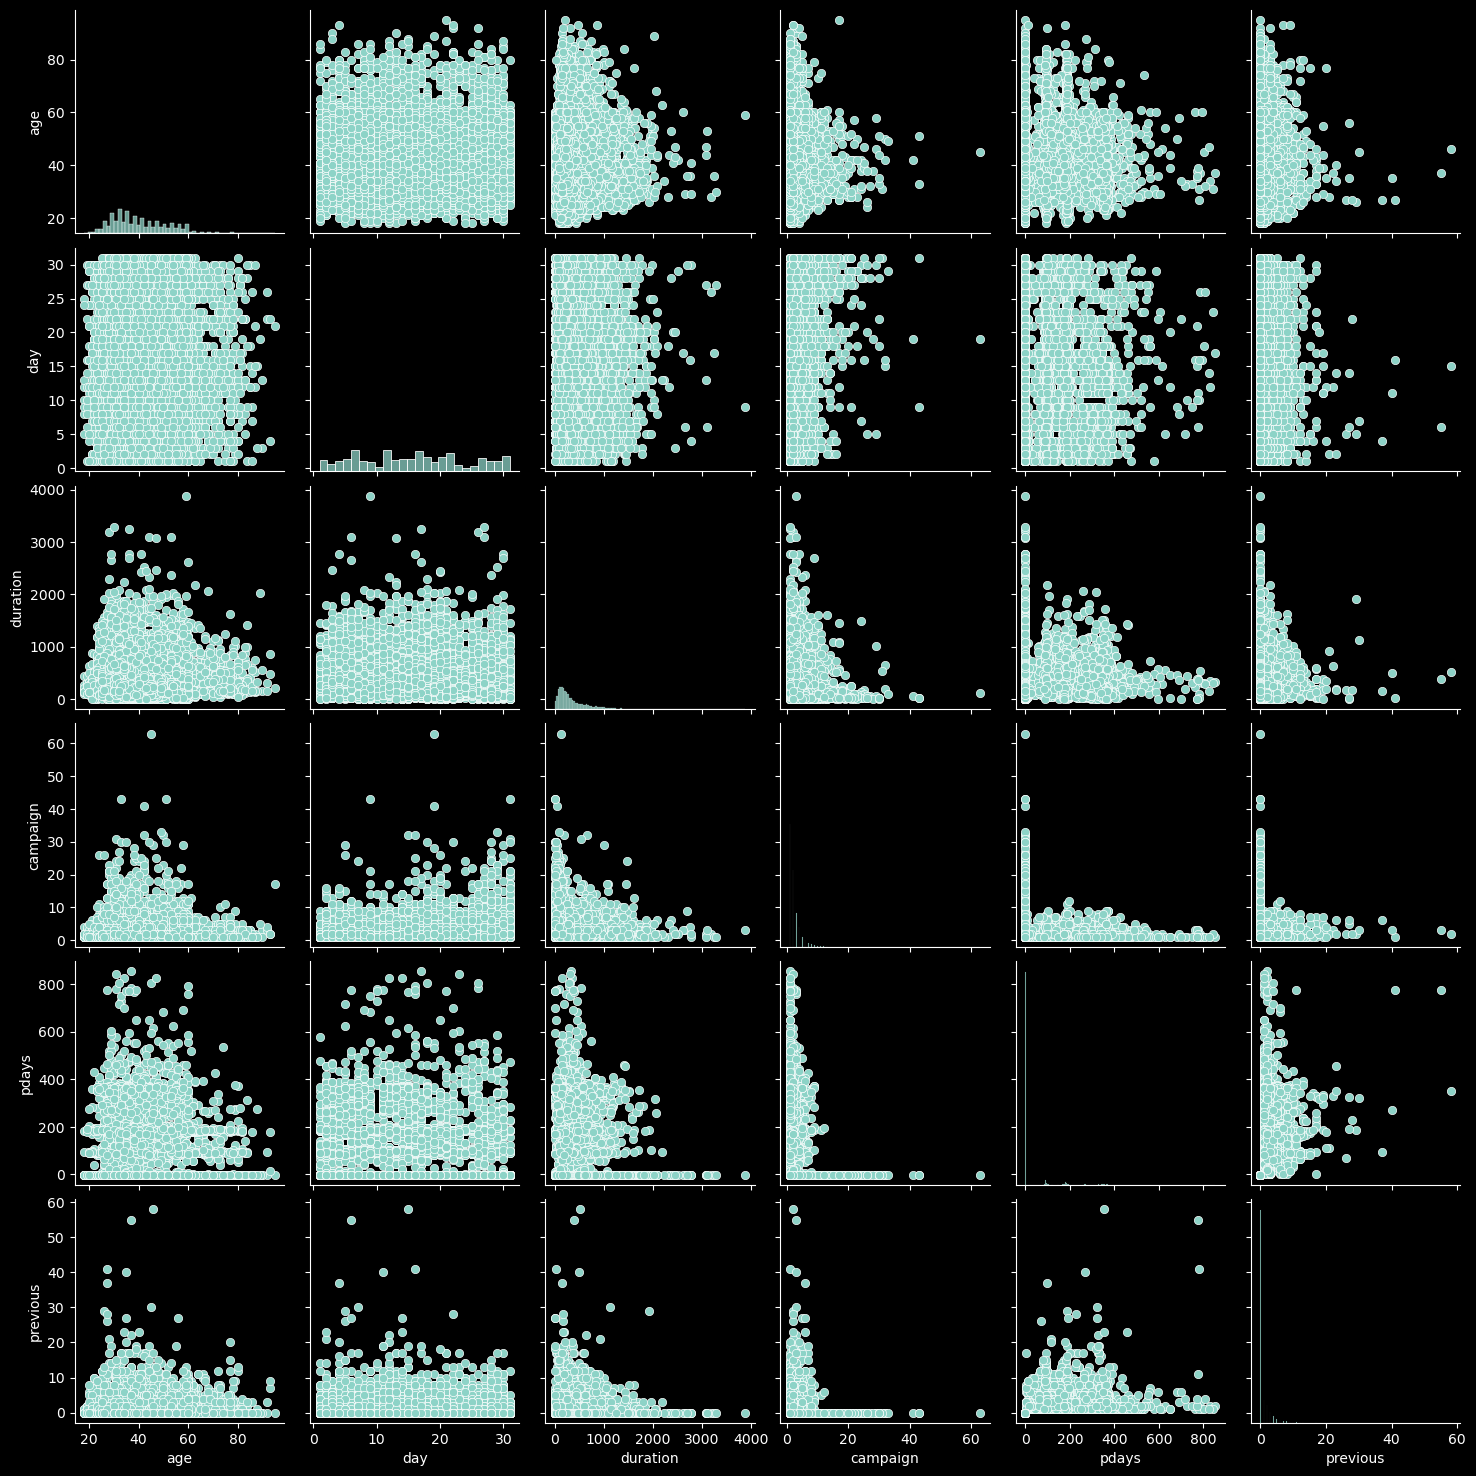

In [1239]:
sns.pairplot(df);

Проверим данные, есть ли в данных пропущенные значения (пустые, незаполненные ячейки).

In [1240]:
nulls = df.isnull().sum()
features_with_nulls = nulls[nulls > 0].sort_values(ascending=False)
print('Признаки с пропусками и их кол-во:', features_with_nulls, sep='\n')

Признаки с пропусками и их кол-во:
balance    25
dtype: int64


Явно пропуски присутствуют лишь в одном признаке - балансе клиента банка. Их количество тоже крайне мало - 25 объектов.

Проверим с помощью функции данные на неявные пропуски, которые могут быть закодированы каким-то словом или набором символов (`'-1'` для числовых и `'unknown'` для категориальных признаков).

In [1241]:
def get_nulls_filled_features(data, filler_list=None):
    result = {'feature': [], 'null_filler': [], 'count': []}
    
    if filler_list is None:
        filler_list = [-1, 'unknown', 'Unknown']
    
    # Цикл по признакам датафрейма
    for feature in data.columns:
        # Серия с уникальными значениями
        unique_values = data[feature].value_counts()
        try:
            # Находим используемый заполнитель пропусков в признаке (не более одного)
            feature_filler = list(set(data[feature].value_counts().index).intersection(filler_list))[0]
            filler_count = unique_values[feature_filler]
            # Вносим в словарь признак, заполнитель пропуска и кол-во пропусков с ним
            result['feature'].append(feature)
            result['null_filler'].append(feature_filler)
            result['count'].append(filler_count)
        except:
            continue
        
    return pd.DataFrame(result)


display(get_nulls_filled_features(df))

,feature,null_filler,count
0,job,unknown,70
1,education,unknown,497
2,contact,unknown,2346
3,pdays,-1,8324
4,poutcome,unknown,8326


Неявные пропуски уже содержаться в 5 признаках: `job`, `education`, `contact`, `pdays` и `poutcome`.

Для их обработки нужно сначала привести другие признаки в корректный тип данных.

Обратим внимание на признак `balance`: в данных содержится лишняя запятая и знак доллара. По этой причине этот признак не считывается как число. Обработаем данные этого признака так, чтобы он был преобразован в тип float. Пропуски пока оставляем без обработки.

In [1242]:
def get_balance(value):
    if pd.isnull(value):    # Пропуски не обрабатываем
        pass
    elif value == '0  $':
        return 0
    else:
        # Отсекаем два последних символа, заменяем точку и убираем пробелы
        return float(value[:-2].replace(',', '.').replace(' ', ''))


df['balance'] = df['balance'].apply(get_balance)

print('Средний баланс клиента банка (с пропусками):', df['balance'].mean().round(3), '$')

Средний баланс клиента банка (с пропусками): 1529.129 $


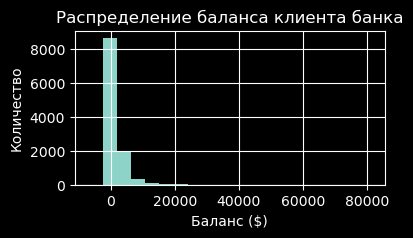

In [1243]:
fig, ax = plt.subplots(figsize=(4, 2))
fig = df['balance'].hist(bins=20)
ax.set_title('Распределение баланса клиента банка')
ax.set_xlabel('Баланс ($)')
ax.set_ylabel('Количество');

Теперь можем заполнить пропуски в балансе. Т.к. распределение баланса является логнормальным, то для заполнения будем использовать медианное значение признака.

In [1244]:
df['balance'].fillna(df['balance'].median(), inplace=True)
print('Средний баланс клиента банка (без пропусков):', df['balance'].mean().round(3), '$')

Средний баланс клиента банка (без пропусков): 1526.936 $


Заполним неявные пропуски в категориальных признаках `job` и `education` их модовым значением. Как мы выяснили ранее, неявный пропуск в данных признаках - `'unknown'`.

Также рассчитаем средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование).

In [1245]:
# Заполняем пропуски модой
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x=='unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x=='unknown' else x)

# Подготавливаем маски для фильтрации
mask1 = df['job'] == df['job'].mode()[0]
mask2 = df['education'] == df['education'].mode()[0]

# Фильтруем объекты по двум маскам и считаем среднее значение
top_balance = round(df[mask1 & mask2]['balance'].mean(), 3)
print('Средний баланс клиентов с самой популярной работой и самым популярным образованием:', top_balance, '$')

Средний баланс клиентов с самой популярной работой и самым популярным образованием: 1598.883 $


Заодно очистим баланс клиентов от выбросов. Т.к. распределение является логнормальными, то для этого воспользуемся методом Тьюки (в нем используется медиана), который, несмотря на свою простоту, хорошо для этого подходит.

Выбросами будем считать данные находящиеся за пределами нижней и верхней границы. Нижняя граница граница определяется как 25 квантиль, из которого вычли полтора межквартильных размаха ($Q25-1.5*IQR$), а верхняя граница - как 75 квантиль, к которому прибавили полтора межквартильных размаха ($Q75+1.5*IQR$). Межквартильный размах равняется разности 75 квантиля к 25 квантилю ($IQR=Q75-Q25$).

In [1246]:
def get_outliers_by_tukey(data, feature):
    x = data[feature]
    Q25, Q75 = x.quantile(0.25), x.quantile(0.75)
    IQR = Q75-Q25
    
    # Нахождение границ и очистка очистка датафрейма
    lower_bound = Q25-1.5*IQR
    upper_bound = Q75+1.5*IQR
    clean_data = data[(x >= lower_bound) & (x <= upper_bound)]
    
    # Вывод границ признака и возвращение очищенного датафрейма
    print(f'Нижняя граница признака {feature}: {lower_bound:.0f}')
    print(f'Верхняя граница признака {feature}: {upper_bound:.0f}')
    return clean_data


df_cleaned = get_outliers_by_tukey(df, 'balance')
print('Кол-во выбросов в признаке баланса:', df.shape[0]-df_cleaned.shape[0])
print('Объектов осталось после удаления выбросов:', df_cleaned.shape[0])

Нижняя граница признака balance: -2241
Верхняя граница признака balance: 4063
Кол-во выбросов в признаке баланса: 1057
Объектов осталось после удаления выбросов: 10105


## Часть 2:  Разведывательный анализ данных (EDA)

В данной части проекта необходимо будет:
- исследовать данные;
- попробовать найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими для оформления депозита;
- дополнить анализ визуализациями, иллюстрирующими наше исследование.

### Баланс целевой переменной

Начнем с изучения распределение целевой переменной (`deposit`) на несбалансированность классов. Чтобы это определить, вычислим частоты для открывших депозит и для тех, кто его не открыл. Также визуализируем результаты.

Количество клиентов открывших депозит: 4681
Количество клиентов не открывших депозит: 5424


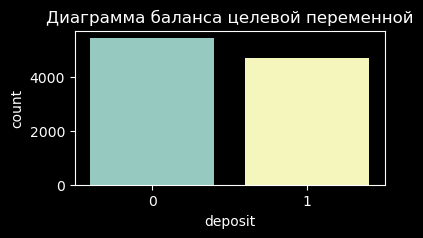

In [1247]:
# Перекодировка таргета в булевый вид
df_cleaned['deposit'] = df_cleaned['deposit'].apply(lambda x: 1 if x=='yes' else 0).astype('int')

print('Количество клиентов открывших депозит:', df_cleaned['deposit'].value_counts()[1])
print('Количество клиентов не открывших депозит:', df_cleaned['deposit'].value_counts()[0])

# Визуализация таргета
fig, ax = plt.subplots(figsize=(4, 2))
fig = sns.countplot(df_cleaned, x='deposit')
ax.set_title('Диаграмма баланса целевой переменной');

Разница в балансе классов незначительная (около 7%) и не требует генерации новых данных путем сэмплирования.

### Описательные статистики

#### Количественные переменные

Посмотрим на описательные статистики для нескольких количественных переменных. Посмотрим на распределение возраста клиентов банка, а также выведем его максимальное значение.

Максимальный возраст: 95


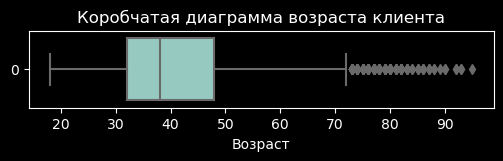

In [1248]:
fig, ax = plt.subplots(figsize=(6, 1))
fig = sns.boxplot(df_cleaned['age'], orient='h')
ax.set_title('Коробчатая диаграмма возраста клиента')
ax.set_xlabel('Возраст');

print('Максимальный возраст:', df_cleaned['age'].max())

Какова минимальная продолжительность разговора с клиентом банка?

In [1249]:
print('Самый короткий звонок (секунд):', df_cleaned['duration'].min())

Самый короткий звонок (секунд): 2


>Максимальный возраст клиента в 95 лет и самая минимальная продолжительность разговора составляет 2 секунды. Это можно проинтерпретировать следующим образом:
>1. Долгоживущие клиенты: Наличие клиентов в возрасте 95 лет указывает на то, что банк привлекает и обслуживает клиентов разного возраста, включая пожилых людей. Это может свидетельствовать о хорошей репутации банка среди этой аудитории и/или о наличии специализированных продуктов или услуг для пожилых клиентов.
>2. Короткие разговоры: Минимальная продолжительность разговора в 2 секунды указывает на то, что некоторые клиенты не проводят много времени на телефоне с сотрудниками компании. Это может иметь различные причины, например, клиенты могут быть занятыми и иметь ограниченное время для разговоров, или они могут предпочитать использовать другие каналы связи, такие как электронная почта или онлайн-чат.

#### Категориальные переменные

Теперь рассмотрим описательные статистики для категориальных переменных.

**1.** Посмотрим сколько было месяцев, в которых проводилась маркетинговая кампания.

Количество месяцев, охватываемых кампанией: 12


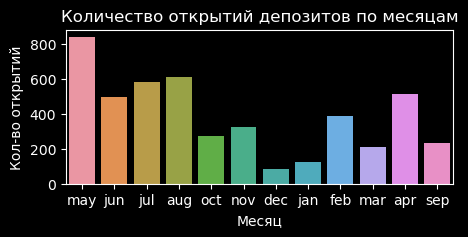

In [1250]:
print('Количество месяцев, охватываемых кампанией:', df_cleaned['month'].value_counts().count())

fig, ax = plt.subplots(figsize=(5, 2))
fig = sns.barplot(df_cleaned, x='month', y='deposit', estimator='sum', ci=False)
ax.set_title('Количество открытий депозитов по месяцам')
ax.set_xlabel('Месяц')
ax.set_ylabel('Кол-во открытий');

>Наблюдаемая разница в количестве открытий счетов в различные месяцы указывает на сезонность поведения клиентов.<br>  
>Пиковые месяцы (апрель, май, июнь, июль, август) свидетельствуют о времени года, когда клиенты более склонны открывать депозитные счета. Это может быть связано с различными факторами, такими как летний отпуск, налоговые сезоны, повышенная финансовая активность или другие внешние обстоятельства, которые могут стимулировать людей к инвестициям.<br>  
>Менее активные месяцы: Декабрь, январь, сентябрь и март отображают меньшее количество открытий счетов. Это может быть связано с различными факторами, такими как праздничный сезон, когда люди склонны тратить деньги на подарки и отпуски, или начало учебного года, когда финансовые приоритеты могут быть направлены на другие расходы.

**2.** Посмотрим на сферы занятости клиентов банка.

Количество сфер занятости клиентов: 11


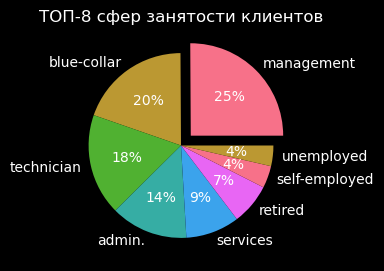

In [1251]:
print('Количество сфер занятости клиентов:', df_cleaned['job'].value_counts().count())

# Визуализируем распределение топ-8
plot_data = df_cleaned['job'].value_counts()[:8]

fig, ax = plt.subplots(figsize=(3, 3))
fig = plt.pie(
    plot_data, labels=plot_data.index,
    autopct='%.0f%%', explode=[0.15, 0, 0, 0, 0, 0, 0, 0],
    colors=sns.color_palette('husl')
    )
ax.set_title('ТОП-8 сфер занятости клиентов');

>Из диаграммы видно разнообразие сфер занятости клиентов банка, с выделяющейся группой людей занятых в сфере управления (management). Такое разнообразие профессиональных областей говорит о том, что банк обслуживает клиентов из различных сфер деятельности, которые могут варьироваться по навыкам, уровню дохода и образованию.  
<br>
>Каждая сфера занятости имеет свои особенности и потребности в финансовых услугах. Например, клиенты из сферы управления могут быть заинтересованы в инвестициях и управлении капиталом, в то время как клиенты "синии воротнички" могут искать кредиты или ипотечные услуги. 

**3.** Узнаем, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь.

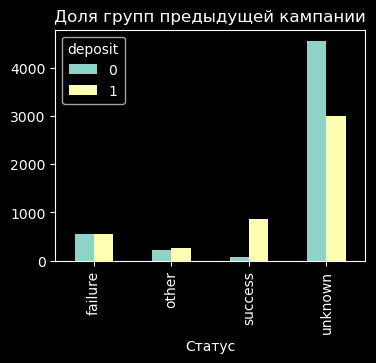

In [1252]:
# Группируем по признаку пред. кампании и смотрим долю клиентов по статусу новой кампании
types = df_cleaned.groupby('poutcome')['deposit'].value_counts().unstack()
types.plot(
    kind='bar', title='Доля групп предыдущей кампании', 
    figsize=(4, 3), xlabel='Статус'
    );

>Превалирование клиентов с успешным статусом (т.е. клиентов, которые открыли депозит) над клиентами других статусов указывает на положительный результат предыдущей маркетинговой кампании. Банк смог привлечь значительное количество клиентов и убедить их в преимуществах и ценности депозитных продуктов.  
<br>
>Преобладание клиентов с успешным статусом также может указывать на то, что маркетинговая кампания была нацелена на правильную аудиторию и успешно обратилась к их потребностям и интересам.

**4.** Ранее мы выявили самые удачные и нет месяцы для открытия новых депозитов клиентами банка. Посмотрим поближе на данные еще раз, но в этот раз учтем факт неудач.

Рассчитаем, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании. Возможно, этот месяц не является подходящим для проведения подобных акций, и это стоит отметить.

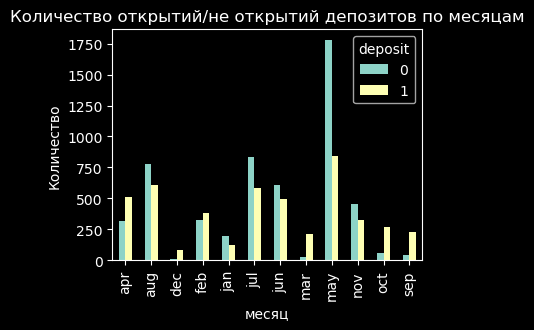

In [1253]:
months = df_cleaned.groupby('month')['deposit'].value_counts().unstack()
months.plot(
    kind='bar', title='Количество открытий/не открытий депозитов по месяцам', 
    figsize=(4, 3), xlabel='месяц', ylabel='Количество'
    );

>Исследование показало, что большинство людей чаще всего отказывались от предложения открыть депозит в мае. Май может быть месяцем, когда у людей возникают другие финансовые обязательства или расходы, так как это период, связанный с праздниками, оплатой налогов или началом летних отпусков. Возможно, в это время люди предпочитают использовать свои средства на другие цели и поэтому не готовы открывать депозиты.

**5.** Нам бы очень хотелось посмотреть, люди какого возраста чаще открывают депозиты, а какого — реже. Однако, так как возрастной разброс достаточно большой (см. описательные статистики по количественным переменам), визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. В аналитике принято разделять людей по возрастным подгруппам и делать выводы уже по ним.

Создадим новую переменную, в которой будет находиться индикатор принадлежности к одной из следующих категорий:
- `<30`
- `30-40`
- `40-50`
- `50-60`
- `60+`

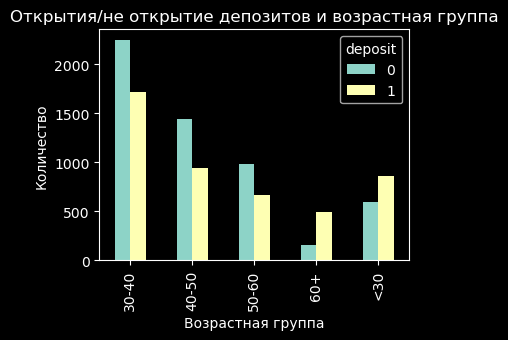

In [1254]:
# Функция присвоения возрастной группы в зависимости от возраста
def get_age_category(age):
    if age < 30: return '<30'
    if 30 <= age < 40: return '30-40'
    if 40 <= age < 50: return '40-50'
    if 50 <= age < 60: return '50-60'
    if age >= 60: return '60+'


# Создаем новую переменную
df_cleaned['age_category'] = df_cleaned['age'].apply(get_age_category)

# Визуализируем новый признак
age_cat = df_cleaned.groupby('age_category')['deposit'].value_counts().unstack()
age_cat.plot(
    kind='bar', 
    title='Открытия/не открытие депозитов и возрастная группа', 
    figsize=(4, 3), xlabel='Возрастная группа', ylabel='Количество'
    );

>Визуализация данных оказывают, что люди в возрасте менее 30 лет и люди в возрасте более 60 лет склонны открывать депозиты, чем отказываться от них после рекламного предложения.  
<br>
>Это может быть связано с финансовой осведомленностью и финансовой стабильностью данных возрастных групп. Люди в возрасте менее 30 лет и более 60 лет, вероятно, имеют более высокий уровень финансовой осведомленности. Молодые люди могут быть заинтересованы в инвестировании и стремиться к долгосрочным финансовым целям, в то время как пожилые люди могут искать способы сохранения и увеличения своих накоплений.

**6.** Посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:
- семейное положение;
- уровень образования;
- сфера занятости.

Сделаем визуализацию, для открывших и не открывших депозит в зависимости от семейного статуса. А также найдем сферу занятости наибольшего количества клиентов банка.

Самая популярная сфера: management


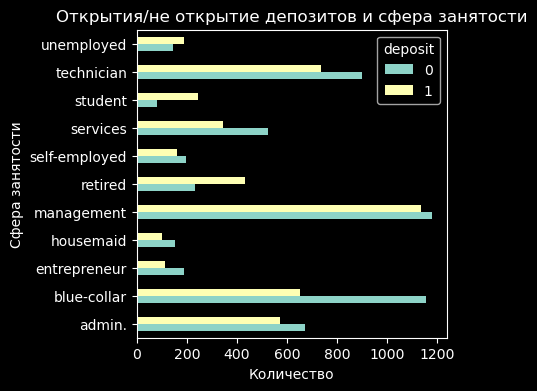

In [1255]:
employment_sector = df_cleaned.groupby('job')['deposit'].value_counts().unstack()
employment_sector.plot(
    kind='barh',
    title='Открытия/не открытие депозитов и сфера занятости', 
    figsize=(4, 4), xlabel='Количество', ylabel='Сфера занятости', 
    );

print('Самая популярная сфера:', df_cleaned['job'].value_counts(ascending=False).index[0])

>Данные показывают, что люди, занятые в сфере рабочих (blue-collar) или являющиеся техническими специалистами, имеют тенденцию чаще отказываться от открытия депозита, в то время как люди пенсионного возраста, студенты и безработные наоборот согласны открыть депозит. Это можно интерпретировать следующим образом:
>1. Финансовые возможности и стабильность: Люди, занятые в сфере рабочих или технических специалистов, могут иметь более ограниченные финансовые возможности и стабильность по сравнению с другими группами. Они могут предпочитать другие способы использования своих средств или иметь меньше доступных средств для инвестиций, поэтому они склонны отказываться от открытия депозита.
>2. Риск и степень уверенности: Люди, занятые в сфере рабочих или технических специалистов, могут быть более осторожными в отношении риска или менее уверенными в отношении своих финансовых решений. Они могут предпочитать более стабильные и непрерывные формы накопления средств, чем депозиты. С другой стороны, пенсионеры, студенты и безработные люди могут чувствовать большую потребность в защите своих средств и быть более открытыми к идеи открытия депозита.

Сделаем похожую визуализацию, для открывших и не открывших депозит, но уже в зависимости от семейного положения.

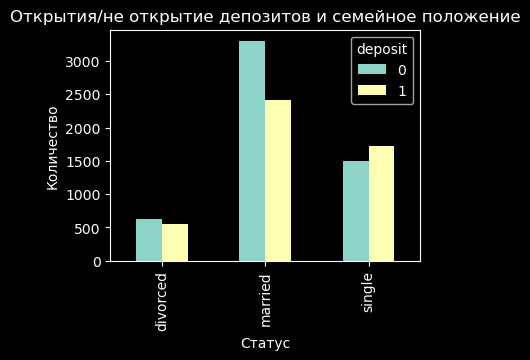

In [1256]:
marital_status = df_cleaned.groupby('marital')['deposit'].value_counts().unstack()
marital_status.plot(
    kind='bar',
    title='Открытия/не открытие депозитов и семейное положение', 
    figsize=(4, 3), xlabel='Статус', ylabel='Количество', 
    );

>Оказывается, что у одиноких людей есть тенденция открывать депозит, а не отказываться от его открытия. Предположим, что холостяки могут иметь большую финансовую независимость по сравнению с теми, кто состоит в отношениях или имеет семью. Они могут принимать финансовые решения самостоятельно и не иметь дополнительных обязательств, которые могут влиять на принятие решений об инвестициях. 

И в завершении посмотрим на данные в разрезе открывших и не открывших депозит в зависимости от уровня образования.

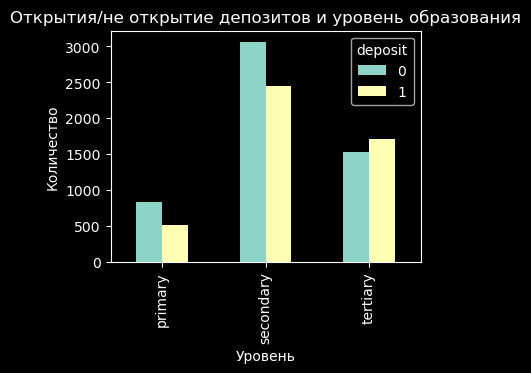

In [1257]:
edu_level = df_cleaned.groupby('education')['deposit'].value_counts().unstack()
edu_level.plot(
    kind='bar',
    title='Открытия/не открытие депозитов и уровень образования', 
    figsize=(4, 3), xlabel='Уровень', ylabel='Количество',
    );

>В наших данных представлены люди со следующим уровнем образования: начальное (`primary`), среднее (`secondary`) и высшее образование (`tertiary`).  
<br>
>Люди с высшим образованием чаще открывают депозит в сравнении с теми у кого его уровень ниже. Это может быть связано с более продолжительным образовательным опытом или специализацией в определенной области. Также данные клиенты могут иметь более осознанный подход к финансовому планированию и будущим целям. Они могут понимать важность накоплений и инвестиций для достижения своих финансовых целей, включая открытие депозита.

**7.** Мы посмотрели различные категории отдельно. Но что будет, если посмотреть на пересечения категорий? Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования?

Разделим данные на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Каждую части сгруппируем по уровню образования и семейному положению и представ результаты в виде тепловых карт.

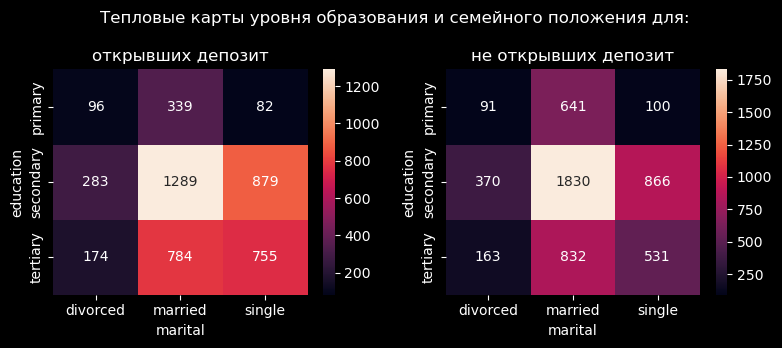

In [1258]:
# Разделяем данные
deposit_opened = df_cleaned[df_cleaned['deposit'] == 1]
deposit_unopened = df_cleaned[df_cleaned['deposit'] == 0]

# Группировка по образованию и сем.положению
deposit_opened_data = deposit_opened.groupby(['education',])['marital'].value_counts().unstack()
deposit_unopened_data = deposit_unopened.groupby(['education',])['marital'].value_counts().unstack()

# Визуализация
fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
sns.heatmap(deposit_opened_data, annot=True, fmt='.0f', ax=ax[0])
sns.heatmap(deposit_unopened_data, annot=True, fmt='.0f', ax=ax[1])
fig.suptitle('Тепловые карты уровня образования и семейного положения для:')
ax[0].set_title('открывших депозит')
ax[1].set_title('не открывших депозит')
plt.tight_layout()

>Особых различий в группах для открывших депозит и для не открывших не наблюдается. За исключением, того, что для обоих групп есть доминантная когорта - люди в семейном положении закончивших среднюю школу. Данные клиенты более склоны не открывать депозит в силу разных обстоятельств (см. рассуждения выше).  
<br>
>Женатые люди часто имеют больше финансовых обязательств, связанных с семьей, чем холостые люди. Они могут иметь более широкий круг расходов, включая выплату ипотеки, образование детей, погашение кредитов и другие семейные затраты. Это может сократить доступные средства для открытия депозита и привести к меньшей склонности к инвестированию.  
<br>
>Принимая еще фактор того, что эти же люди имеют среднее образование, они могут обладать менее развитыми финансовыми знаниями и навыками по сравнению с людьми, обладающими более высоким уровнем образования. Это может привести к недостатку информации или понимания о преимуществах и возможностях, которые предоставляют депозитные счета. В результате, они могут быть менее склонны к их открытию.

## Часть 3: Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё один шаг.

- Алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. По ходу работы алгоритм считает показатели (например, средние значения), которые можно вычислить только для количественных признаков. Поэтому нам необходимо преобразовать категориальные признаки в более удобный формат.

- Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить качество модели.

- Надо отобрать признаки, которые мы будем использовать для обучения модели.

### Кодировка признаков

Начнем с обработки категориальных признаков, а именно с их порядкового кодирования. Посмотрим на имеющиеся признаки:

In [1259]:
display(df_cleaned.select_dtypes('object').sample(5, random_state=1))

,job,marital,education,default,housing,loan,contact,month,poutcome,age_category
5550,housemaid,married,primary,no,yes,no,cellular,feb,failure,30-40
6724,technician,divorced,secondary,no,yes,yes,cellular,jul,unknown,50-60
924,retired,divorced,secondary,no,no,no,unknown,nov,unknown,50-60
3064,technician,married,tertiary,no,no,no,cellular,jan,unknown,30-40
3171,student,married,secondary,no,no,no,cellular,feb,success,30-40


Для данного кодирования идеально подходит признак уровня образования (`education`) и созданный ранее признака возрастной группы клиента банка (`age_category`).

In [1260]:
# Кодировщик
le_encoder = preprocessing.LabelEncoder()

# Кодирование образования
encoded_edu = pd.Series(
    le_encoder.fit_transform(df_cleaned['education']),
    name='education'
    )

# Кодирование возраста
encoded_age = pd.Series(
    le_encoder.fit_transform(df_cleaned['age_category']),
    name='age_category'
    )

# Объединяем закодированный признак с датасетом
df_encoded = pd.concat(
    [df_cleaned.reset_index(drop=True).drop(['education', 'age_category'], axis=1),
    encoded_edu, encoded_age], axis=1
    )

Следующие на очереди бинарные переменные, которых в наших данных три - 	`default`, `housing`, `loan`.

In [1261]:
df_encoded['default'] = df_encoded['default'].apply(lambda x: 1 if x=='yes' else 0)
df_encoded['housing'] = df_encoded['housing'].apply(lambda x: 1 if x=='yes' else 0)
df_encoded['loan'] = df_encoded['loan'].apply(lambda x: 1 if x=='yes' else 0)

Остались преобразовать номинальные переменные, которые могут принимать несколько различных значений: `job`, `marital`, `contact`, `month` и `poutcome`. Закодируем их методом One hot encoding.

In [1262]:
oh_features_list = ['job', 'marital', 'contact', 'month', 'poutcome']

# Кодировщик
oh_encoder = preprocessing.OneHotEncoder()

# Процесс кодирования
dummed_data = oh_encoder.fit_transform(df_encoded[oh_features_list]).toarray()
dummed_features_name = oh_encoder.get_feature_names_out(oh_features_list)
dummed_data_df = pd.DataFrame(dummed_data, columns=dummed_features_name).astype('int')

# Объединяем закодированные признаки с датасетом
df_encoded = pd.concat(
    [df_encoded.drop(oh_features_list, axis=1),
    dummed_data_df], axis=1)

print('Общее число факторов после кодировки OHE:', df_encoded.shape[1]-1)

Общее число факторов после кодировки OHE: 45


### Отбор признаков

#### На базе мультиколлинеарности

Оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

Для этого построим тепловую карту на базе матрицы корреляции. А в качестве дополнительной визуализации построим столбчатую диаграмму для ранжированных коэффициентов корреляции.

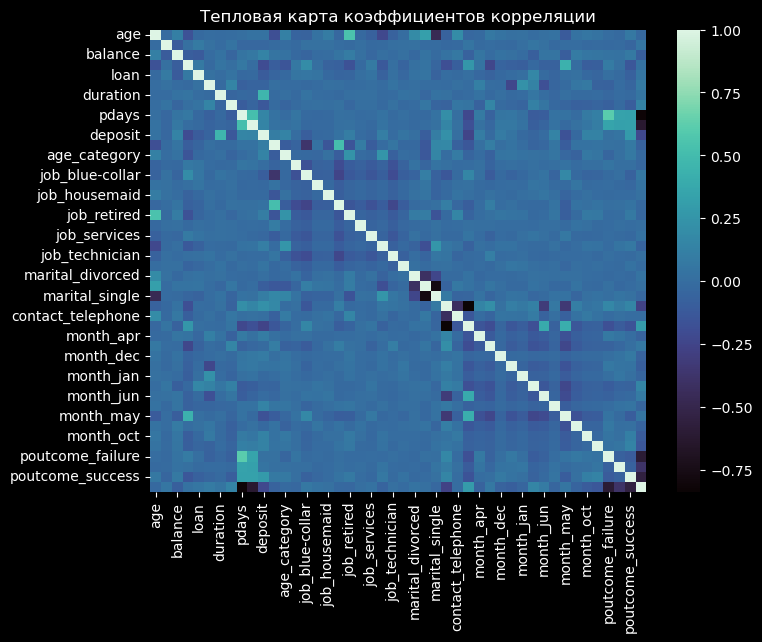

In [1263]:
# Построение матрицы корреляций
corr_matrix = df_encoded.select_dtypes('number').corr()

# Визуализация тепловой карты
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.heatmap(corr_matrix, cmap='mako')
ax.set_title('Тепловая карта коэффициентов корреляции');

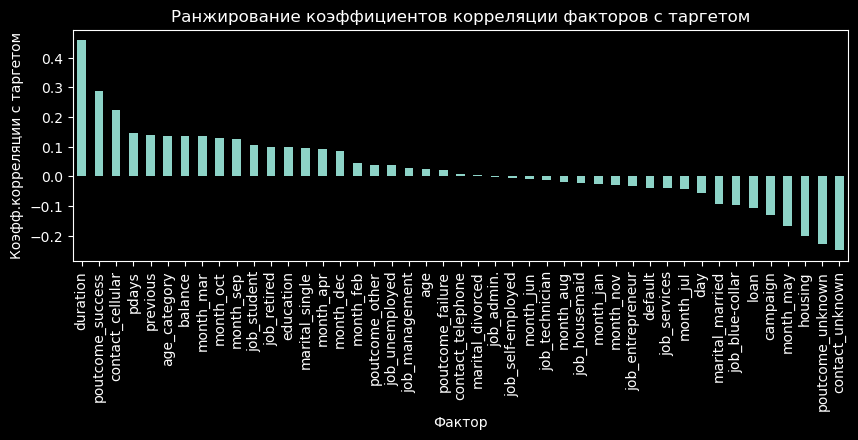

In [1264]:
# Сортировка коэффициентов корреляции по убыванию
sorted_corr = corr_matrix.unstack().sort_values(ascending=False)

# Удаление повторяющихся пар и таргета
mask1 = sorted_corr.index.get_level_values(0) != sorted_corr.index.get_level_values(1)
mask2 = sorted_corr.index.get_level_values(0) == 'deposit'
sorted_corr = sorted_corr[mask1 & mask2]

# Визуализация столбчатой диаграммы
sorted_corr.droplevel(0).plot(
    kind='bar', title='Ранжирование коэффициентов корреляции факторов с таргетом',
    figsize=(10, 3), xlabel='Фактор', ylabel='Коэфф.корреляции с таргетом'
    );

Признаки с наибольшей степенью коррелирующие с целевой переменной, по убыванию силы линейной взаимосвязи: `duration`, `poutcome_success` и `contact_cellular`.

Если брать в расчет коэффициент мультиколлинеарности равный 0.7, то среди признаков таковых нету.

#### На основе фильтров (статистик)

Теперь определим целевую переменную и предикторы, а также разделим выборку на обучающую и тестовую в соотношении 0.33. Также сохраним баланс целевого признака в обоих выборках.

In [1265]:
X = df_encoded.drop(['deposit'], axis=1)
y = df_encoded['deposit']
 
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.33, stratify=y, random_state=42)

print(X_train.shape, X_test.shape)
display(X_train.head())

(6770, 45) (3335, 45)


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
6542,34,0,557.0,1,0,16,513,1,-1,0,...,0,0,0,0,0,0,0,0,0,1
4230,34,0,69.0,0,1,25,296,1,205,2,...,0,0,0,1,0,0,1,0,0,0
5079,33,0,0.0,1,0,5,399,2,358,5,...,0,0,1,0,0,0,0,1,0,0
2265,37,0,444.0,0,0,14,137,1,102,5,...,0,0,0,0,0,0,0,0,1,0
8386,39,0,1444.0,0,0,19,100,1,117,8,...,0,0,0,1,0,0,0,0,1,0


Как видно, на данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью фильтров отберем 15 признаков, наилучшим образом подходящих для использования в задаче. В качестве фильтра, для выбора признаков, будем использовать статистический критерий, а именно дисперсионный анализ ANOVA (входящие признаки числовые, а выходной признак категориальный) и SelectKBest из библиотеки sklearn.

In [1266]:
# Селектор выбора k лучших признаков
selector = feature_selection.SelectKBest(
    score_func=feature_selection.f_classif,     # Библиотека реализующая ANOVA
    k=15)

# Получаем список лучших признаков
selector.fit(X_train, y_train)
best_features_list = selector.get_feature_names_out()
print('15 отобранных признаков:', best_features_list, sep='\n')

# Оставляем только отобранные признаки
X_train_selected = X_train[best_features_list]
X_test_selected = X_test[best_features_list]

15 отобранных признаков:
['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous'
 'age_category' 'contact_cellular' 'contact_unknown' 'month_mar'
 'month_may' 'month_oct' 'month_sep' 'poutcome_success' 'poutcome_unknown']


In [1267]:
# Описательные статистики по признакам
X_train.iloc[:, :11].describe().T

,count,mean,std,min,25%,50%,75%,max
age,6770.0,40.765288,11.686669,18.0,32.0,38.0,48.00,93.0
default,6770.0,0.016248,0.126438,0.0,0.0,0.0,0.00,1.0
balance,6770.0,805.087297,995.709709,-2049.0,92.0,442.0,1227.00,4063.0
housing,6770.0,0.479321,0.499609,0.0,0.0,0.0,1.00,1.0
loan,6770.0,0.140768,0.347808,0.0,0.0,0.0,0.00,1.0
day,6770.0,15.539734,8.459752,1.0,8.0,15.0,22.00,31.0
duration,6770.0,371.134417,350.628525,2.0,138.0,255.0,486.75,3881.0
campaign,6770.0,2.516544,2.720295,1.0,1.0,2.0,3.00,43.0
pdays,6770.0,50.921123,108.993529,-1.0,-1.0,-1.0,-1.00,854.0
previous,6770.0,0.803988,2.220418,0.0,0.0,0.0,0.00,58.0


Настало время отмасштабировать данные. Есть разные варианты, но мы на этапе знакомства с данными визуализировали распределения изначальных признаков - все они не были Гауссового вида. Поэтому данные нужно нормализовать: используем для этого MinMax-нормализацию, т.к. описательные статистики выше показали, что значение среднего и медианы находятся на одном уровне (в признаке баланса мы ранее убрали выбросы методом Тьюки).

In [1268]:
# Нормализатор
minmax_scaler = preprocessing.MinMaxScaler()

# Подставляем и получаем тренировочную выборку
X_train_selected_scaled = pd.DataFrame(
    minmax_scaler.fit_transform(X_train_selected, y_train),
    columns=best_features_list)

# Получаем тестовую выборку
X_test_selected_scaled = pd.DataFrame(
    minmax_scaler.transform(X_test_selected),
    columns=best_features_list)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

Для удобного вывода, логирования и дальнейшего сравнивания результатов каждой модели напишем функции.

In [1269]:
# Словарь скоров проекта
proj_scores = {
    'Model': [], 'Subset': [], 'Accuracy': [],
    'Precision': [], 'Recall': [], 'F1 score': [],
    'Duration': []}

# Функция для подсчета метрик классификации
def get_metrics(y_true, y_pred, model_name, subset, pround, time, breakline=False):
    # Подсчет метрик
    accuracy_score = metrics.accuracy_score(y_true, y_pred)
    precision_score = metrics.precision_score(y_true, y_pred)
    recall_score = metrics.recall_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)

    # Логирование метрик в словарь
    proj_scores['Model'].append(model_name)
    proj_scores['Subset'].append(subset)
    proj_scores['Accuracy'].append(accuracy_score)
    proj_scores['Precision'].append(precision_score)
    proj_scores['Recall'].append(recall_score)
    proj_scores['F1 score'].append(f1_score)
    proj_scores['Duration'].append(time)

    # Вывод
    if breakline: print('-'*40)
    print(f'{model_name} {subset} Accuracy score {round(accuracy_score, pround)}')
    print(f'{model_name} {subset} Precision score {round(precision_score, pround)}')
    print(f'{model_name} {subset} Recall score {round(recall_score, pround)}')
    print(f'{model_name} {subset} F1 score {round(f1_score, pround)}')


# Подсветка максимальных, минимальных и переобучения
def highlight_values(series):
    # Работаем только с числовыми данными
    if pd.api.types.is_numeric_dtype(series):

        # Раскраска для признака времени
        if series.name == 'Duration':
            # Создать серию с параметром True для нужно значения в столбце и False для остальных
            is_max = series == series.max()
            is_min = series == series.min()

            # Применяем стили на основе заданных условий
            styles = []
            for max_val, min_val in zip(is_max, is_min):
                if min_val:
                    styles.append('font-weight: bold; color: green')
                elif max_val:
                    styles.append('font-weight: bold; color: red')
                else:
                    styles.append('')
            return styles

        # Раскраска для других чисел
        else: 
            # Создать серию с параметром True для нужно значения в столбце и False для остальных
            is_max = series == series[series != 1].max()
            is_min = series == series.min()
            is_value_one = series == 1

            # Применяем стили на основе заданных условий
            styles = []
            for max_val, min_val, is_value_one in zip(is_max, is_min, is_value_one):
                if max_val and not is_value_one:
                    styles.append('font-weight: bold; color: green')
                elif is_value_one:
                    styles.append('font-weight: bold; color: yellow')
                elif min_val:
                    styles.append('font-weight: bold; color: red')
                else:
                    styles.append('')
            return styles

    # Возвращается пустой список для нечисловых столбцов
    else: return [''] * len(series)

## Логическая регрессия

Для начала реализуем самый простой алгоритм, который вам известен — логистическую регрессию. В качестве алгоритма оптимизации будем использовать стохастический градиентный спуск с максимальным количество итераций 1000. Остальные параметры оставьте по умолчанию.

In [1270]:
start = time()          # Логирование продолжительности

# Модель логистической регрессии
model_lr = linear_model.LogisticRegression(
    solver='sag', max_iter=1000, random_state=42)
model_lr.fit(X_train_selected_scaled, y_train)

end = time()-start

# Предсказание
y_train_pred = model_lr.predict(X_train_selected_scaled)
y_test_pred = model_lr.predict(X_test_selected_scaled)

# Подсчет и вывод метрик
get_metrics(y_train, y_train_pred, 'LogisticRegression', 'train', 2, end)
get_metrics(y_test, y_test_pred, 'LogisticRegression', 'test', 2, end, breakline=True)

LogisticRegression train Accuracy score 0.82
LogisticRegression train Precision score 0.84
LogisticRegression train Recall score 0.76
LogisticRegression train F1 score 0.8
----------------------------------------
LogisticRegression test Accuracy score 0.8
LogisticRegression test Precision score 0.83
LogisticRegression test Recall score 0.73
LogisticRegression test F1 score 0.78


## Деревья решений

Простой алгоритм обучен. Теперь обучим ещё один алгоритм — решающие деревья. В качестве критерия информативности будем использовать энтропию Шеннона. Остальные параметры оставьте по умолчанию.

In [1271]:
start = time()          # Логирование продолжительности

# Модель решающего дерева
model_dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
model_dt.fit(X_train_selected_scaled, y_train)

end = time()-start

# Предсказание
y_train_pred = model_dt.predict(X_train_selected_scaled)
y_test_pred = model_dt.predict(X_test_selected_scaled)

# Подсчет и вывод метрик
get_metrics(y_train, y_train_pred, 'DecisionTreeClassifier default', 'train', 2, end)
get_metrics(y_test, y_test_pred, 'DecisionTreeClassifier default', 'test', 2, end, breakline=True)

DecisionTreeClassifier default train Accuracy score 1.0
DecisionTreeClassifier default train Precision score 1.0
DecisionTreeClassifier default train Recall score 1.0
DecisionTreeClassifier default train F1 score 1.0
----------------------------------------
DecisionTreeClassifier default test Accuracy score 0.75
DecisionTreeClassifier default test Precision score 0.74
DecisionTreeClassifier default test Recall score 0.71
DecisionTreeClassifier default test F1 score 0.72


На лицо переобучение модели решающего дерева: без явного указания глубины данные модели склоны подстраиваться под тренировочную выборку.

Переберем в различные максимальные глубины деревьев и найдем глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

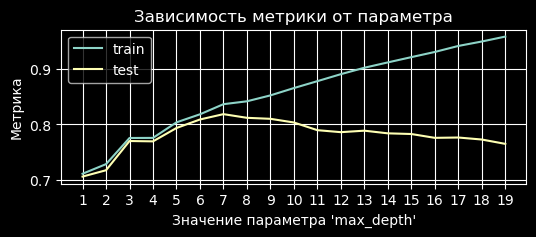

In [1272]:
train_score_list, test_score_list = [], []  # Списки для метрик
max_depth_range = np.arange(1, 20, 1)       # Диапазон глубины

# Перебор значение длины дерева с подсчетом метрики и ее добавлением в список
for i in max_depth_range:
    model = tree.DecisionTreeClassifier(
        criterion='entropy', max_depth=i, random_state=42)
    model.fit(X_train_selected_scaled, y_train)
    y_train_pred = model.predict(X_train_selected_scaled)
    y_test_pred = model.predict(X_test_selected_scaled)
    train_score_list.append(metrics.accuracy_score(y_train, y_train_pred))
    test_score_list.append(metrics.accuracy_score(y_test, y_test_pred))

# Визуализируем график
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(max_depth_range, train_score_list, label='train')
ax.plot(max_depth_range, test_score_list, label='test')
ax.xaxis.set_ticks(max_depth_range)
ax.set_title('Зависимость метрики от параметра')
ax.set_xlabel("Значение параметра 'max_depth'")
ax.set_ylabel('Метрика')
ax.legend()
ax.grid()

Результат 6 и 7 очень близки. Метрика для значения 7 показывают немного лучший результат, но есть небольшой нюанс. Разность между метрикой на тренировочном и тестовой выборке для глубины = 6 меньше, а это значит, что если говорить про переобучение модели, то вариант с меньшей дельтой предпочтительнее. По этой причине принимаем оптимальным значением глубины дерева значение 6. Построим модель с данным значением параметра.

In [1273]:
start = time()          # Логирование продолжительности

# Модель решающего дерева
model_dt_tunned = tree.DecisionTreeClassifier(
    criterion='entropy', max_depth=6,
    random_state=42)
model_dt_tunned.fit(X_train_selected_scaled, y_train)

end = time()-start

# Предсказание
y_train_pred = model_dt_tunned.predict(X_train_selected_scaled)
y_test_pred = model_dt_tunned.predict(X_test_selected_scaled)

# Подсчет и вывод метрик
get_metrics(
    y_train, y_train_pred, 'DecisionTreeClassifier hand-tunned', 
    'train', 2, end)
get_metrics(
    y_test, y_test_pred, 'DecisionTreeClassifier hand-tunned',
    'test', 2, end, breakline=True)

DecisionTreeClassifier hand-tunned train Accuracy score 0.82
DecisionTreeClassifier hand-tunned train Precision score 0.78
DecisionTreeClassifier hand-tunned train Recall score 0.85
DecisionTreeClassifier hand-tunned train F1 score 0.81
----------------------------------------
DecisionTreeClassifier hand-tunned test Accuracy score 0.81
DecisionTreeClassifier hand-tunned test Precision score 0.77
DecisionTreeClassifier hand-tunned test Recall score 0.84
DecisionTreeClassifier hand-tunned test F1 score 0.8


Разумеется, у каждой модели может быть множество параметров. Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. Поэтому мы можем использовать оптимизацию: можно перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

В библиотеке sklearn есть класс для поиска лучших параметров по заданной сетке - GridSearchCV. Воспользуемся им и найдем лучшие по метрике F1 score параметры из списков:
- `'max_depth': [3, 5, 7]`
- `'min_samples_split': [2, 5, 7, 10]`

In [1274]:

# Сетка параметров
param_grid = {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 7, 10]}

start = time()          # Логирование продолжительности

# Поиск по сетке с кросс-валидацией
gridsearch_dt = model_selection.GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42),
    param_grid=param_grid, scoring='f1', n_jobs=-1, cv=3)

# Обучение и вывод лучших параметров
gridsearch_dt.fit(X_train_selected_scaled, y_train)
print('Лучшие найденные параметры:', gridsearch_dt.best_params_)

end = time()-start

# Предсказание
y_train_pred = gridsearch_dt.predict(X_train_selected_scaled)
y_test_pred = gridsearch_dt.predict(X_test_selected_scaled)

# Подсчет и вывод метрик
get_metrics(
    y_train, y_train_pred, 'DecisionTreeClassifier GridSearchCV',
    'train', 2, end, breakline=True)
get_metrics(
    y_test, y_test_pred, 'DecisionTreeClassifier GridSearchCV',
    'test', 2, end, breakline=True)

Лучшие найденные параметры: {'max_depth': 7, 'min_samples_split': 5}
----------------------------------------
DecisionTreeClassifier GridSearchCV train Accuracy score 0.84
DecisionTreeClassifier GridSearchCV train Precision score 0.81
DecisionTreeClassifier GridSearchCV train Recall score 0.84
DecisionTreeClassifier GridSearchCV train F1 score 0.83
----------------------------------------
DecisionTreeClassifier GridSearchCV test Accuracy score 0.82
DecisionTreeClassifier GridSearchCV test Precision score 0.79
DecisionTreeClassifier GridSearchCV test Recall score 0.82
DecisionTreeClassifier GridSearchCV test F1 score 0.81


## Вывод по несложным моделям

Соберем все результаты в таблицы и выделем минимальные и максимальные метрики, а также потенциальное переобучение - метрика равна единице.

In [1275]:
proj_scores_df = pd.DataFrame(proj_scores)
proj_scores_df_train = proj_scores_df[proj_scores_df['Subset'] == 'train']
proj_scores_df_test = proj_scores_df[proj_scores_df['Subset'] == 'test']
display(proj_scores_df_train.style.apply(highlight_values))
display(proj_scores_df_test.style.apply(highlight_values))

,Model,Subset,Accuracy,Precision,Recall,F1 score,Duration
0,LogisticRegression,train,0.824372,0.843386,0.762436,0.800871,0.030076
2,DecisionTreeClassifier default,train,1.000000,1.000000,1.000000,1.000000,0.036001
4,DecisionTreeClassifier hand-tunned,train,0.818316,0.776874,0.852679,0.813013,0.014004
6,DecisionTreeClassifier GridSearchCV,train,0.836189,0.814654,0.836735,0.825547,2.569288


,Model,Subset,Accuracy,Precision,Recall,F1 score,Duration
1,LogisticRegression,test,0.804798,0.825328,0.733981,0.776978,0.030076
3,DecisionTreeClassifier default,test,0.747226,0.735887,0.708738,0.722057,0.036001
5,DecisionTreeClassifier hand-tunned,test,0.808996,0.768322,0.841424,0.803213,0.014004
7,DecisionTreeClassifier GridSearchCV,test,0.817691,0.794099,0.818770,0.806246,2.569288


Как видно, самая сильная получилась модель на базе решающего дерева с правильно подобранными гипер-параметрами. Самая слабая модель, имеющая к тому же переобучение, тоже решающее дерево, но уже с параметрами по умолчанию. Из этого можно сделать промежуточный вывод о том, что решающее дерево хорошо справляется с задачей, но требует время на подбор параметров (модель затребовала больше всего времени). 

Далее попробуем более сложные модели и варианты оптимизации.

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Случайный лес

Пришло время усложнить модели, а также посмотреть, улучшится ли результат (если да, то насколько). Мы обучали решающие деревья, и теперь пришла пора объединить их в случайный лес.

In [1276]:
start = time()          # Логирование продолжительности

# Модель случайного леса
model_rf = ensemble.RandomForestClassifier(
    n_estimators=100, criterion='gini',
    max_depth=10, min_samples_leaf=5, random_state=42)
model_rf.fit(X_train_selected_scaled, y_train)

end = time()-start

# Предсказание
y_train_pred = model_rf.predict(X_train_selected_scaled)
y_test_pred = model_rf.predict(X_test_selected_scaled)

# Подсчет и вывод метрик
get_metrics(y_train, y_train_pred, 'RandomForestClassifier', 'train', 3, end)
get_metrics(y_test, y_test_pred, 'RandomForestClassifier', 'test', 3, end, breakline=True)

RandomForestClassifier train Accuracy score 0.858
RandomForestClassifier train Precision score 0.838
RandomForestClassifier train Recall score 0.859
RandomForestClassifier train F1 score 0.848
----------------------------------------
RandomForestClassifier test Accuracy score 0.828
RandomForestClassifier test Precision score 0.803
RandomForestClassifier test Recall score 0.835
RandomForestClassifier test F1 score 0.819


Метрики улучшались для обоих выборок по сравнению с самой сильной простой моделью - решающего дерева с оптимизацией.

### Градиентный бустинг над решающими деревьями

Теперь попробуем еще более сложную модель - градиентный бустинг над решающими деревьями для решения задачи классификации.

In [1277]:
start = time()          # Логирование продолжительности

# Модель градиентного бустинга над деревьями решений
model_gbdt = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, 
    max_depth=5, min_samples_leaf=5, random_state=42)
model_gbdt.fit(X_train_selected_scaled, y_train)

end = time()-start

# Предсказание
y_train_pred = model_gbdt.predict(X_train_selected_scaled)
y_test_pred = model_gbdt.predict(X_test_selected_scaled)

# Подсчет и вывод метрик
get_metrics(y_train, y_train_pred, 'GradientBoostingClassifier', 'train', 3, end)
get_metrics(y_test, y_test_pred, 'GradientBoostingClassifier', 'test', 3, end, breakline=True)

GradientBoostingClassifier train Accuracy score 0.888
GradientBoostingClassifier train Precision score 0.873
GradientBoostingClassifier train Recall score 0.887
GradientBoostingClassifier train F1 score 0.88
----------------------------------------
GradientBoostingClassifier test Accuracy score 0.827
GradientBoostingClassifier test Precision score 0.802
GradientBoostingClassifier test Recall score 0.832
GradientBoostingClassifier test F1 score 0.817


Использование более сложной модели на заданных нами параметрах не дало более качественный прогноз.

### Ансамблирование

Попробуем использовать метод стекинга нескольких моделей для построения ансамбля из моделей. Объединим ранее использованные модели: решающие деревья, логическую регрессию и градиентный бустинг. А в качестве метамодели будем использовать логическую регрессию. Гипер-параметры моделей оставим те же, что ранее в проекте.

In [1278]:
start = time()          # Логирование продолжительности

# Список моделей для стекинга
estimators = [
    ('dt', tree.DecisionTreeClassifier(**gridsearch_dt.best_estimator_.get_params())),
    ('lr', linear_model.LogisticRegression(**model_lr.get_params())),
    ('gb', ensemble.GradientBoostingClassifier(**model_gbdt.get_params()))]

# Стекинг моделей
model_stack = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42),
    n_jobs=-1)
model_stack.fit(X_train_selected_scaled, y_train)

end = time()-start

# Предсказание
y_train_pred = model_stack.predict(X_train_selected_scaled)
y_test_pred = model_stack.predict(X_test_selected_scaled)

# Подсчет и вывод метрик
get_metrics(y_train, y_train_pred, 'StackingClassifier', 'train', 3, end)
get_metrics(y_test, y_test_pred, 'StackingClassifier', 'test', 3, end, breakline=True)

StackingClassifier train Accuracy score 0.87
StackingClassifier train Precision score 0.86
StackingClassifier train Recall score 0.858
StackingClassifier train F1 score 0.859
----------------------------------------
StackingClassifier test Accuracy score 0.822
StackingClassifier test Precision score 0.805
StackingClassifier test Recall score 0.812
StackingClassifier test F1 score 0.809


Разумеется, не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, давайте выберем три признака, дающих наибольший вклад.

Для этого возьмем модель ранжирование факторов из модели Градиентного бустинга над решающими деревьями.

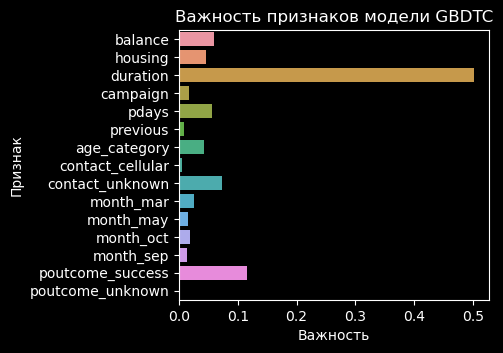

In [1279]:
fig, ax = plt.subplots(figsize=(4, 3.5))
sns.barplot(x=model_gbdt.feature_importances_, y=best_features_list)
ax.set_title('Важность признаков модели GBDTC')
ax.set_xlabel('Важность')
ax.set_ylabel('Признак');

In [1280]:
df['contact'].value_counts(normalize=True)

cellular     0.720480
unknown      0.210177
telephone    0.069342
Name: contact, dtype: float64

Три самых важных признака для модели: продолжительность контакта в секундах, положительный результат прошлой маркетинговой кампании, тип неустановленный тип контакта с клиентом.

>Давайте рассмотрим возможные объяснения, почему именно эти три признака получили наивысшую важность:
>1. **Продолжительность контакта в секундах.** Продолжительность контакта с клиентом может быть ключевым фактором, определяющим степень вовлеченности клиента и его интерес к предлагаемому продукту или услуге. Более длительные разговоры могут свидетельствовать о более глубоком обсуждении или объяснении преимуществ депозитного продукта, что может повышать вероятность того, что клиент согласится на открытие депозита.
>2. **Положительный результат прошлой маркетинговой кампании.** Этот признак указывает на успешный опыт клиента с предыдущей маркетинговой кампанией банка. Если клиент реагировал положительно на предыдущую кампанию, это может свидетельствовать о его заинтересованности в банковских продуктах и готовности открывать депозит.
>3. **Неизвестный тип связи.** Возможно, признак контакта с пропусками коррелирует с другими признаками в данных, которые являются сильными предикторами открытия депозита. Например, это может быть связано с определенной группой клиентов или с определенными характеристиками клиентов, которые имеют важное значение для предсказания.

### Optuna

Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи GridSearchCV. Однако это не единственный способ. Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк Optuna. Примените его для оптимизации гиперпараметров. Для перебора возьмите случайный лес и следующие параметры:
- `n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)`
- `max_depth = trial.suggest_int('max_depth', 10, 30, 1)`
- `min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)`

In [1281]:
# Список метрик для оптимизации
metrics_list = ['accuracy', 'precision', 'recall', 'F1 score']

# Ищем лучшие параметры под заданную метрику
for model_metric in metrics_list:
    
    start = time()          # Логирование продолжительности
    
    # Функция оптимизации параметров для случайного леса
    def optuna_rf(trial):
        n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
        max_depth = trial.suggest_int('max_depth', 10, 30, 1)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
        
        model = ensemble.RandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth, 
            min_samples_leaf=min_samples_leaf, random_state=42)
        model.fit(X_train_selected_scaled, y_train)
        
        # Подсчет соответствующей метрики
        if model_metric == 'accuracy':
            return metrics.accuracy_score(y_test, model.predict(X_test_selected_scaled))
        elif model_metric == 'precision':
            return metrics.precision_score(y_test, model.predict(X_test_selected_scaled))
        elif model_metric == 'recall':
            return metrics.recall_score(y_test, model.predict(X_test_selected_scaled))
        elif model_metric == 'F1 score':
            return metrics.f1_score(y_test, model.predict(X_test_selected_scaled))

    # Объект исследования
    study = optuna.create_study(direction='maximize')
    study.optimize(func=optuna_rf, n_trials=30, n_jobs=-1)
    
    # Вывод параметров
    print(f'Наилучшие параметры для максимизации метрики {model_metric}:')
    print(' ', study.best_params)
    
    # Обучаем модель на найденных параметрах
    model_rf = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
    model_rf.fit(X_train_selected_scaled, y_train)
    
    end = time()-start
    
    # Предсказание
    y_train_pred = model_rf.predict(X_train_selected_scaled)
    y_test_pred = model_rf.predict(X_test_selected_scaled)

    # Подсчет и вывод метрик
    get_metrics(
        y_train, y_train_pred, f'RandomForestClassifier Optuna (maximize {model_metric})',
        'train', 3, end, breakline=True)
    get_metrics(
        y_test, y_test_pred, f'RandomForestClassifier Optuna (maximize {model_metric})',
        'test', 3, end, breakline=True)
    
    print('*'*40)

Наилучшие параметры для максимизации метрики accuracy:
  {'n_estimators': 174, 'max_depth': 14, 'min_samples_leaf': 3}
----------------------------------------
RandomForestClassifier Optuna (maximize accuracy) train Accuracy score 0.884
RandomForestClassifier Optuna (maximize accuracy) train Precision score 0.861
RandomForestClassifier Optuna (maximize accuracy) train Recall score 0.893
RandomForestClassifier Optuna (maximize accuracy) train F1 score 0.877
----------------------------------------
RandomForestClassifier Optuna (maximize accuracy) test Accuracy score 0.831
RandomForestClassifier Optuna (maximize accuracy) test Precision score 0.802
RandomForestClassifier Optuna (maximize accuracy) test Recall score 0.843
RandomForestClassifier Optuna (maximize accuracy) test F1 score 0.822
****************************************
Наилучшие параметры для максимизации метрики precision:
  {'n_estimators': 164, 'max_depth': 10, 'min_samples_leaf': 2}
----------------------------------------



Построим **График истории оптимизации**. Он отображает количество испытаний на оси Х и метрику на оси Y.

In [1283]:
fig = optuna.visualization.plot_optimization_history(study, target_name='f1_score')
fig.update_layout(template='plotly_dark')

В нашем случаи оптимальные параметры найден на первых итерациях.

Построим **График важности гиперпараметров**. Он помогает понять, какие гиперпараметры вносят больший вклад в максимизацию метрики F1 скор.

In [1284]:
fig = optuna.visualization.plot_param_importances(study, target_name='f1_score')
fig.update_layout(template='plotly_dark')

Из графика можно сделать вывод, что стоит обратить большее внимание на настройку гипер-параметра `min_samples_leaf`.

## Вывод по проекту

Соберем результаты по всем моделям в таблицы и выделем минимальные и максимальные метрики, а также потенциальное переобучение - метрика равна единице.

In [1282]:
proj_scores_df = pd.DataFrame(proj_scores)
proj_scores_df_train = proj_scores_df[proj_scores_df['Subset'] == 'train']
proj_scores_df_test = proj_scores_df[proj_scores_df['Subset'] == 'test']
display(proj_scores_df_train.style.apply(highlight_values))
display(proj_scores_df_test.style.apply(highlight_values))

,Model,Subset,Accuracy,Precision,Recall,F1 score,Duration
0,LogisticRegression,train,0.824372,0.843386,0.762436,0.800871,0.030076
2,DecisionTreeClassifier default,train,1.000000,1.000000,1.000000,1.000000,0.036001
4,DecisionTreeClassifier hand-tunned,train,0.818316,0.776874,0.852679,0.813013,0.014004
6,DecisionTreeClassifier GridSearchCV,train,0.836189,0.814654,0.836735,0.825547,2.569288
8,RandomForestClassifier,train,0.857755,0.837947,0.859056,0.848370,0.495122
10,GradientBoostingClassifier,train,0.887888,0.872687,0.887436,0.880000,3.324347
12,StackingClassifier,train,0.869719,0.860064,0.858418,0.859240,7.803163
14,RandomForestClassifier Optuna (maximize accuracy),train,0.883752,0.861496,0.892538,0.876742,13.538729
16,RandomForestClassifier Optuna (maximize precision),train,0.869424,0.849039,0.873406,0.861050,13.056749
18,RandomForestClassifier Optuna (maximize recall),train,0.881241,0.857230,0.892219,0.874375,14.339065


,Model,Subset,Accuracy,Precision,Recall,F1 score,Duration
1,LogisticRegression,test,0.804798,0.825328,0.733981,0.776978,0.030076
3,DecisionTreeClassifier default,test,0.747226,0.735887,0.708738,0.722057,0.036001
5,DecisionTreeClassifier hand-tunned,test,0.808996,0.768322,0.841424,0.803213,0.014004
7,DecisionTreeClassifier GridSearchCV,test,0.817691,0.794099,0.818770,0.806246,2.569288
9,RandomForestClassifier,test,0.828486,0.802738,0.834951,0.818528,0.495122
11,GradientBoostingClassifier,test,0.826987,0.801746,0.832362,0.816767,3.324347
13,StackingClassifier,test,0.821889,0.805003,0.812298,0.808634,7.803163
15,RandomForestClassifier Optuna (maximize accuracy),test,0.830885,0.802218,0.842718,0.821970,13.538729
17,RandomForestClassifier Optuna (maximize precision),test,0.826987,0.802122,0.831715,0.816651,13.056749
19,RandomForestClassifier Optuna (maximize recall),test,0.830285,0.800123,0.844660,0.821788,14.339065


В проекте машинного обучения для выявления клиентов, более склонных к открытию депозита в банке на основе данных прошлого маркетингового исследования, были использованы различные модели с целью определить наиболее эффективный подход для прогнозирования поведения клиентов.

Основной вывод состоит в том, что выбор модели машинного обучения играет важную роль в достижении более точных прогнозов. Были опробованы простые модели, такие как логистическая регрессия и решающее дерево, которые позволяют быстро построить модель, но результаты их прогнозов оказались менее качественными. Это может быть обусловлено тем, что простые модели не способны улавливать сложные взаимосвязи и неустойчивы к шуму в данных.

С другой стороны, более сложные модели, такие как случайный лес и модели на базе градиентного бустинга, показали лучшие результаты. Они способны обрабатывать сложные структуры данных и находить нелинейные зависимости между признаками. Кроме того, при оптимизации гиперпараметров, эти модели становятся ещё более точными и устойчивыми к различным вариациям данных.

Однако стоит отметить, что более сложные модели требуют больше времени для обучения из-за большего объема вычислений и процесса оптимизации гиперпараметров. Это может быть значимым фактором при работе с большими объемами данных или ограниченными вычислительными ресурсами. Поэтому в реальных ситуациях необходимо найти компромисс между временем обучения и качеством модели.

В итоге, для достижения наилучших результатов в прогнозировании поведения клиентов банка, рекомендуется использовать более сложные модели, такие как случайный лес или градиентный бустинг, с оптимизацией гиперпараметров. Однако при необходимости быстрой моделирования или при ограниченных ресурсах можно также рассмотреть использование простых моделей, хотя они могут иметь меньшую точность прогнозов.